In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import util as u
import text_processing as tp
%load_ext autoreload
%autoreload 2

from sklearn.metrics.pairwise import cosine_similarity

from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance

In [2]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

### Load data

In [4]:
df = u.open_pkl('Data/all_lyrics_with_sim_df_9_topics.pkl')
df.rename(columns={'Median Most Sim Idx':'Median Most Sim'}, inplace=True)
country_idx_start = np.min(list(df[df['Genre'] == 'country'].index))

df['Genre_Most_Sim'] = df['Median Most Sim'].apply(lambda x: 'rap' if x < country_idx_start else 'country')

rap_df = df[df['Genre'] == 'rap']
cnty_df = df[df['Genre'] == 'country']

transX = u.open_pkl('Data/tf_sparse_mtx.pkl')
lda_X = u.open_pkl('Data/lda_transformed_mtx.pkl')
# lda_topics = u.open_pkl('Data/lda_topics_9.pkl')
# hd_mtx = u.open_pkl('Data/hd_sim_lda_mtx.pkl')  # Hellinger Distance between document LDA feature vectors

### Swap order of "columns" in lda_X to match order of topics in pyLDAvis
In pyLDAvis: topic 1 = topic 7 in lda_X, & 
topic 2 = topic 5

In [5]:
lda_X_orig = lda_X.copy()
lda_df = pd.DataFrame(lda_X)

In [7]:
lda_df.head()

,0,1,2,3,4,5,6,7,8
0,0.000182,0.000182,0.000182,0.000182,0.000182,0.014153,0.000182,0.984577,0.000182
1,0.093289,0.000177,0.000177,0.000177,0.000177,0.540790,0.000177,0.364859,0.000177
2,0.000145,0.000145,0.000145,0.708916,0.000145,0.290068,0.000145,0.000145,0.000145
3,0.000161,0.000161,0.000161,0.520857,0.000161,0.236241,0.000161,0.241935,0.000161
4,0.000341,0.000341,0.000341,0.400660,0.000341,0.596950,0.000341,0.000341,0.000341


In [6]:
new_cols_order = [7,5,0,1,2,3,4,6,8]
lda_df = lda_df[new_cols_order]

In [9]:
lda_df.head()

,7,5,0,1,2,3,4,6,8
0,0.984577,0.014153,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182
1,0.364859,0.540790,0.093289,0.000177,0.000177,0.000177,0.000177,0.000177,0.000177
2,0.000145,0.290068,0.000145,0.000145,0.000145,0.708916,0.000145,0.000145,0.000145
3,0.241935,0.236241,0.000161,0.000161,0.000161,0.520857,0.000161,0.000161,0.000161
4,0.000341,0.596950,0.000341,0.000341,0.000341,0.400660,0.000341,0.000341,0.000341


In [7]:
lda_X = lda_df.as_matrix()

In [11]:
u.pp_lda(0, lda_X)

0: 0.9846
1: 0.0142
2: 0.0002
3: 0.0002
4: 0.0002
5: 0.0002
6: 0.0002
7: 0.0002
8: 0.0002


In [12]:
u.pp_lda(0, lda_X_orig)

0: 0.0002
1: 0.0002
2: 0.0002
3: 0.0002
4: 0.0002
5: 0.0142
6: 0.0002
7: 0.9846
8: 0.0002


In [8]:
u.pkl_this("Data/lda_reordered_for_gscore.pkl", lda_X)

#### Do same for lda_topics

In [9]:
# lda_topics_orig = lda_topics
# lda_topics = [lda_topics_orig[x] for x in new_cols_order]

# u.pkl_this("Data/lda_topics_reordered_for_gscore.pkl", lda_topics)

### Define Colors

In [9]:
tc_color, cr_color, tr_color = ['#d8b365','#999999','#5ab4ac']
cat1_color, cat2_color = ['xkcd:medium blue', 'xkcd:powder blue']
clu1_color, clu2_color = ['xkcd:purple blue', 'xkcd:pastel purple']

### Comparing individual songs' LDA vectors

In [10]:
def lda_plot_data(idx):
    d = lda_X[idx]
    d1 = d[0]
    d2 = d[1]
    drest = np.sum(d[2:])
    return [d1, d2, drest]

In [11]:
u.gangsta_score(114, lda_X)

8.201800744000414

In [12]:
u.gangsta_score(1491, lda_X)

-7.722093499109423

In [13]:
r = lda_plot_data(114) 
c = lda_plot_data(2001)

/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


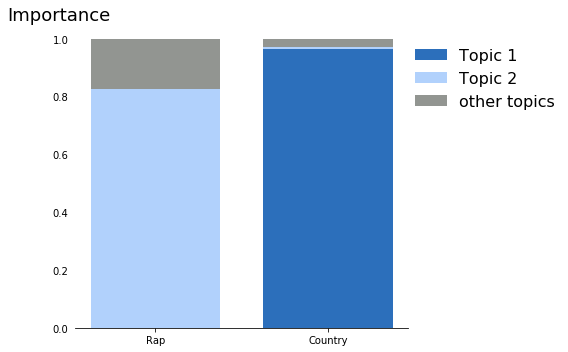

In [16]:
n = 2
xs = np.arange(n)
w = 0.75
plt.figure(figsize=(8,5))
plt.bar(xs, [r[0], c[0]], width=w, label='Topic 1', color=cat1_color)
plt.bar(xs, [r[1], c[1]], width=w, bottom=[r[0], c[0]], label='Topic 2', color=cat2_color)
plt.bar(xs, [r[2], c[2]], width=w, bottom=[r[0] + r[1], c[0] + c[1]], label='other topics', color='xkcd:grey')


# plt.bar(xs[::3]-0.5, lda_X[2000, [5,7]], width=w, label='Country')
ax = plt.gca()
# hide_axes(ax, False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(bottom)
ax.spines['left'].set_visible(False)

plt.tick_params(left=False) #, labelleft=False, bottom=bottom, labelbottom=bottom) #, labelbottom='on')

plt.xticks(xs, ["Rap", "Country"])#[f'{x}' for x in xs])
ax.set_ylabel('Importance', rotation=0, fontsize=18)
ax.yaxis.set_label_coords(-0.05,1.0)

plt.legend(fontsize=16, loc=(1, 0.7), frameon=False);
plt.savefig('Images/topic_impt_2_songs.png', dpi=300, transparent=False)

## Clustering

#### K-Means, k=2, cosine distance

In [10]:
n_clust = 2

In [11]:
rap_label_pcts = [np.sum(rap_df['Cluster Labels 2 Cosine'] == i)/len(rap_df) for i in range(n_clust)] 
cnty_label_pcts = [np.sum(cnty_df['Cluster Labels 2 Cosine'] == i)/len(cnty_df) for i in range(n_clust)] 

Plot by cluster:

/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


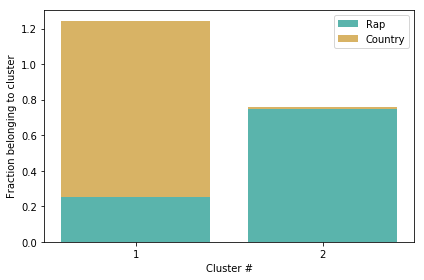

In [12]:
plt.bar(range(n_clust), rap_label_pcts, color=tr_color, label='Rap')
plt.bar(range(n_clust), cnty_label_pcts, bottom=rap_label_pcts, color=tc_color, label='Country')
plt.xlabel('Cluster #')
plt.ylabel('Fraction belonging to cluster')
plt.xticks(range(n_clust), labels=[f'{i+1}' for i in range(n_clust)])
plt.legend();

Plot by genre

/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


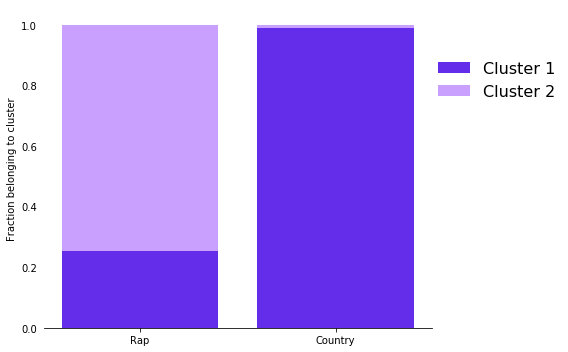

In [13]:
plt.figure(figsize=(8,5))
plt.bar(range(n_clust), [rap_label_pcts[0], cnty_label_pcts[0]], color=clu1_color, label='Cluster 1')
plt.bar(range(n_clust), [rap_label_pcts[1], cnty_label_pcts[1]], bottom=[rap_label_pcts[0], cnty_label_pcts[0]], 
        color=clu2_color, label='Cluster 2')
plt.ylabel('Fraction belonging to cluster')
plt.xticks(range(n_clust), ['Rap', 'Country'])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(bottom)
ax.spines['left'].set_visible(False)

plt.tick_params(left=False) #, labelleft=False, bottom=bottom, labelbottom=bottom) #, labelbottom='on')

plt.legend(fontsize=16, loc=(1, 0.7), frameon=False);
plt.savefig('Images/clusters.png', dpi=300, transparent=False)

### Rap songs more similar to country songs

In [14]:
rap_artist_val_counts = rap_df['Artist'].value_counts()
rap_artists = rap_artist_val_counts.index
rap_cnty = rap_df[(rap_df['Cluster Labels 2 Cosine'] == 0) & (rap_df['Median Most Sim'] >= country_idx_start)]

len(rap_cnty), len(rap_cnty) / len(rap_df)

(85, 0.08341511285574092)

In [15]:
def number_country_cluster(artist):
#     tot_n_songs = artist_val_counts[artist]
    n_cnty_songs = len(rap_cnty[rap_cnty['Artist'] == artist])
    return n_cnty_songs

In [16]:
rap_artist_cnty_nums = []
for a in rap_artists:
    rap_artist_cnty_nums.append(number_country_cluster(a))

In [17]:
test = pd.DataFrame(rap_artist_val_counts)
test2 = pd.DataFrame(index = rap_artists, data = rap_artist_cnty_nums)
test3 = test.join(test2)
test3.columns = ['total # songs', '# country songs']
test3['% country songs'] = test3['# country songs'] / test3['total # songs'] * 100
test3.sort_values('% country songs', inplace=True, ascending=False)

rap_cnty_df = test3[test3['total # songs'] > 3]

### "Rap-rap" artists/songs
Are their song lyrics distinct?

In [18]:
rap_rap = rap_df[(rap_df['Cluster Labels 2 Cosine'] == 1) & (rap_df['Median Most Sim'] < country_idx_start)]
len(rap_rap), len(rap_rap) / len(rap_df)

(757, 0.7428851815505397)

In [19]:
def number_rap_cluster(artist):
#     tot_n_songs = artist_val_counts[artist]
    n_rap_songs = len(rap_rap[rap_rap['Artist'] == artist])
    return n_rap_songs

In [20]:
rap_artist_rap_nums = []
for a in rap_artists:
    rap_artist_rap_nums.append(number_rap_cluster(a))

In [21]:
test = pd.DataFrame(rap_artist_val_counts)
test2 = pd.DataFrame(index = rap_artists, data = rap_artist_rap_nums)
test3 = test.join(test2)
test3.columns = ['total # songs', '# rap songs']
test3['% rap songs'] = test3['# rap songs'] / test3['total # songs'] * 100
test3.sort_values('% rap songs', inplace=True, ascending=False)

rap_rap_df = test3[test3['total # songs'] > 3]

### Highest probability topics for "country-rap" (rap_cnty) songs

In [22]:
rap_df.groupby(['Genre_Most_Sim','Cluster Labels 2 Cosine'])['Song'].count()

Genre_Most_Sim  Cluster Labels 2 Cosine
country         0                           85
                1                            3
rap             0                          174
                1                          757
Name: Song, dtype: int64

In [23]:
rap_cnty_ldas = [lda_X[i] for i in rap_cnty.index]
rap_cnty_lda_df = pd.DataFrame(data=rap_cnty_ldas, index = rap_cnty.index)

rap_rap_ldas = [lda_X[i] for i in rap_rap.index]
rap_rap_lda_df = pd.DataFrame(data=rap_rap_ldas, index = rap_rap.index)

In [24]:
rap_other_idxs = set(rap_df.index).difference(set(list(rap_cnty.index) + list(rap_rap.index)))
rap_other_ldas = [lda_X[i] for i in rap_other_idxs]
rap_other_lda_df = pd.DataFrame(data=rap_other_ldas, index = rap_other_idxs)

In [25]:
rap_cnty_lda_df['cat'] = 'country rap'
rap_rap_lda_df['cat'] = 'true rap'
rap_other_lda_df['cat'] = 'impure rap'

rap_lda_df = pd.concat([rap_rap_lda_df, rap_cnty_lda_df, rap_other_lda_df])

In [26]:
cols = list(rap_lda_df.columns)
cols.remove('cat')

In [27]:
rap_lda_unstacked = [[i, col, rap_lda_df.loc[i, col], rap_lda_df.loc[i, 'cat']] for col in cols for i in rap_lda_df.index]
rap_lda_unstacked_df = pd.DataFrame(rap_lda_unstacked, columns = ['song_idx', 'topic', 'topic_impt','cat'])

In [28]:
rap_vioin_df1 = rap_lda_unstacked_df[(rap_lda_unstacked_df['cat'] == 'country rap') | (rap_lda_unstacked_df['cat'] == 'true rap')]

/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


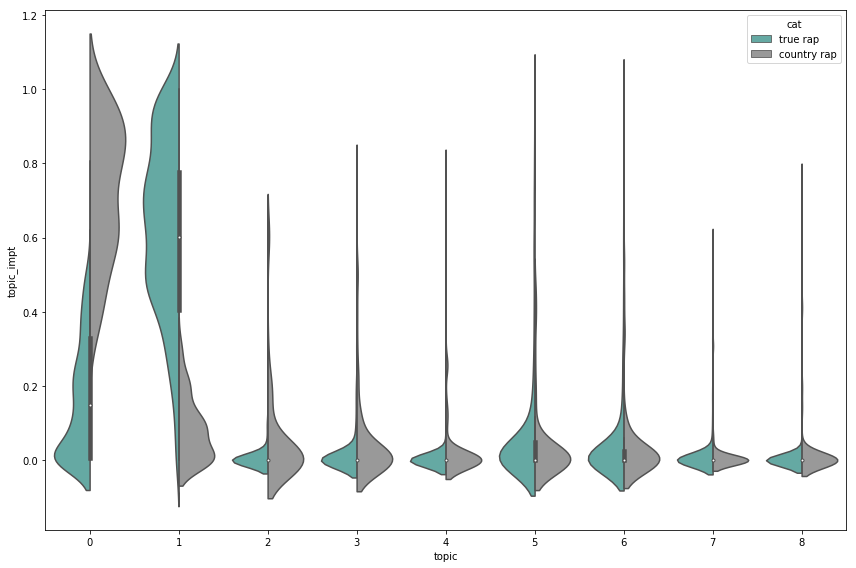

In [29]:
fig = plt.figure(figsize=(12,8))

sns.violinplot(x="topic", y="topic_impt", hue="cat", data=rap_vioin_df1, 
               split='True', scale='width',
#                pallete={"left": 'red', "right": 'o'});
               palette={"true rap": tr_color, "country rap": cr_color});

### Country songs

In [30]:
cnty_df.groupby(['Genre_Most_Sim','Cluster Labels 2 Cosine'])['Song'].count()

Genre_Most_Sim  Cluster Labels 2 Cosine
country         0                          1700
                1                             3
rap             0                            56
                1                            17
Name: Song, dtype: int64

In [31]:
cnty_idxs = cnty_df.index
cnty_ldas = [lda_X[i] for i in cnty_idxs]
cnty_lda_df = pd.DataFrame(data=cnty_ldas, index = cnty_idxs)
cnty_cnty = cnty_df[(cnty_df['Cluster Labels 2 Cosine'] == 0) & (cnty_df['Median Most Sim'] >= country_idx_start)]

len(cnty_cnty), len(cnty_cnty) / len(cnty_df)

(1700, 0.9572072072072072)

In [32]:
cnty_cnty_ldas = [lda_X[i] for i in cnty_cnty.index]
cnty_cnty_lda_df = pd.DataFrame(data=cnty_cnty_ldas, index = cnty_cnty.index)
cnty_cnty_lda_df['cat'] = 'true country'

In [33]:
cnty_lda_unstacked = [[i, col, cnty_cnty_lda_df.loc[i, col], 
                       cnty_cnty_lda_df.loc[i, 'cat']] for col in cols for i in cnty_cnty_lda_df.index]
cnty_lda_unstacked_df = pd.DataFrame(cnty_lda_unstacked, columns = ['song_idx', 'topic', 'topic_impt','cat'])

In [34]:
holder = pd.concat([rap_cnty_lda_df, cnty_cnty_lda_df])
unstacked = [[i, col, holder.loc[i, col], holder.loc[i, 'cat']] for col in cols for i in holder.index]
combo_lda_df1 = pd.DataFrame(unstacked, columns = ['song_idx', 'topic', 'topic_impt','cat'])

In [35]:
holder = pd.concat([rap_rap_lda_df, cnty_cnty_lda_df])
unstacked = [[i, col, holder.loc[i, col], holder.loc[i, 'cat']] for col in cols for i in holder.index]
combo_lda_df2 = pd.DataFrame(unstacked, columns = ['song_idx', 'topic', 'topic_impt','cat'])

In [36]:
all_rap_lda_unstacked_df = rap_lda_unstacked_df.copy()
all_rap_lda_unstacked_df['cat'] = 'rap'
all_cnty_lda_unstacked_df = cnty_lda_unstacked_df.copy()
all_cnty_lda_unstacked_df['cat'] = 'country'
all_lda_unstacked_df = pd.concat([all_rap_lda_unstacked_df, all_cnty_lda_unstacked_df])

In [37]:
ts = np.arange(9)

/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


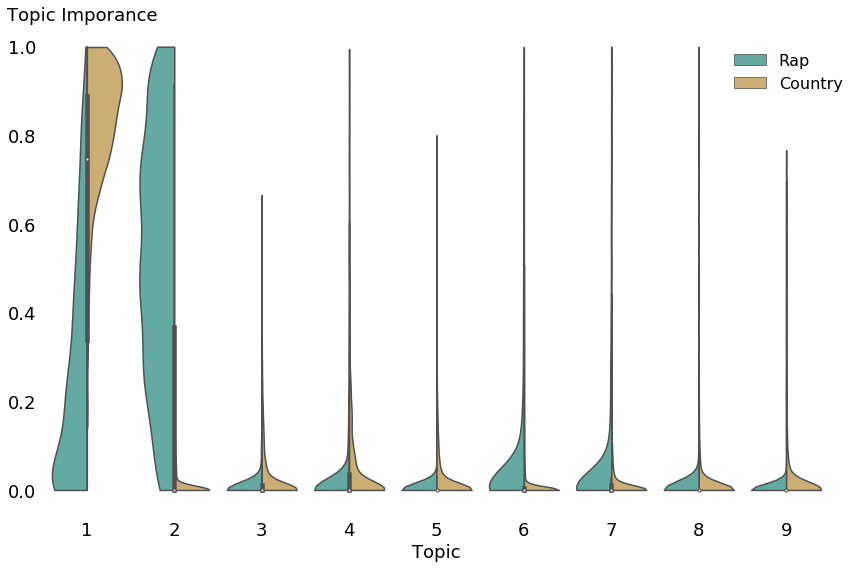

In [38]:
fig = plt.figure(figsize=(12,8))

sns.violinplot(x="topic", y="topic_impt", hue="cat", data=all_lda_unstacked_df, 
               split='True', scale='width', cut=0,
               palette={"rap": tr_color, "country": tc_color});
# plt.title('Topic imporance by Genre')
# plt.ylabel('Topic Importance', fontsize=14)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tick_params(bottom=False, left=False )#, labelleft='off', labelbottom='on')
plt.xticks(ts, [f'{i+1}' for i in ts], fontsize=18)
plt.xlabel('Topic', fontsize=18)

ax.set_ylabel('Topic Imporance', rotation=0, fontsize=18)
ax.yaxis.set_label_coords(0.05,1.0)
# plt.yticks([0,1],['0.0','1.0'], fontsize=18);
plt.yticks(fontsize=18);


handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['Rap','Country'], fontsize=16, frameon=False, loc=(0.87, 0.85)); 
plt.savefig('Images/Topic_Importance_by_Genre.png', dpi=300, transparent=False)

In [39]:
unstacked_df = pd.concat([rap_lda_unstacked_df, cnty_lda_unstacked_df])

In [40]:
df_topic2 = unstacked_df[unstacked_df['topic'] == 1];
df_topic1 = unstacked_df[unstacked_df['topic'] == 0];

/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


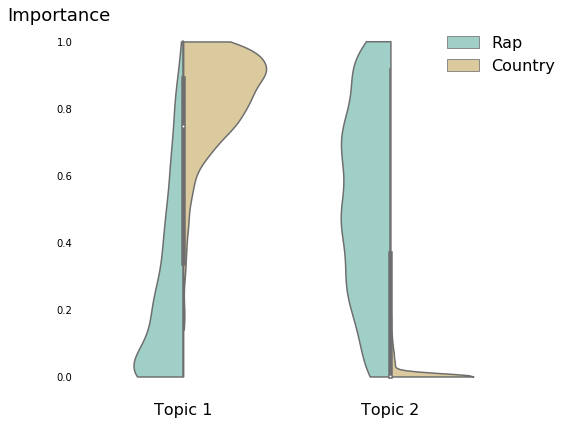

In [41]:
temp_rap_unstacked_df = rap_lda_unstacked_df.copy()
temp_rap_unstacked_df['cat'] = 'rap'
temp_unstacked_df = pd.concat([temp_rap_unstacked_df, cnty_lda_unstacked_df])
df_topic2 = temp_unstacked_df[temp_unstacked_df['topic'] == 1];
df_topic1 = temp_unstacked_df[temp_unstacked_df['topic'] == 0];
df_topic = pd.concat([df_topic1, df_topic2])

plt.figure(figsize=(8,6)), #gridspec_kw = {'width_ratios':[1,0.2,1]})

sns.violinplot(x="topic", y="topic_impt", data=df_topic, scale='count', cut=0, hue="cat", palette="BrBG_r", 
               split=True)
plt.xticks([0,1], ['Topic 1','Topic 2'], fontsize=16)
plt.xlabel('')
plt.ylabel('Topic Importance', fontsize=18)

ax = plt.gca()
u.hide_axes(ax, False, False, False, False)
plt.tick_params(bottom=False, left=False) , #labelleft=False)

ax.set_ylabel('Importance', rotation=0, fontsize=18)
ax.yaxis.set_label_coords(-0.05,1.0)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['Rap','Country'], fontsize=16, frameon=False, loc=(0.87, 0.85)); #bbox_to_anchor=(0.5, 0., 0.5, 0.5));
plt.savefig('Images/Topic_Importance_by_Genre_split_violin_2.png', dpi=300, transparent=False);


In [48]:
cnty_lda_df.head()

,0,1,2,3,4,5,6,7,8,cat,Log_Diff
1019,0.893605,0.000518,0.000518,0.102767,0.000518,0.000518,0.000518,0.000518,0.000518,country,-7.452265
1020,0.664670,0.000300,0.000300,0.333227,0.000300,0.000300,0.000300,0.000300,0.000300,country,-7.701963
1021,0.922114,0.000341,0.000341,0.000341,0.000341,0.000341,0.000341,0.075496,0.000341,country,-7.901330
1022,0.785377,0.000267,0.000267,0.000267,0.187150,0.000267,0.025872,0.000267,0.000267,country,-7.987654
1023,0.657257,0.000241,0.000241,0.341056,0.000241,0.000241,0.000241,0.000241,0.000241,country,-7.910942


In [49]:
rap_lda_df.head()

,0,1,2,3,4,5,6,7,8,cat
1,0.364859,0.540790,0.093289,0.000177,0.000177,0.000177,0.000177,0.000177,0.000177,true rap
2,0.000145,0.290068,0.000145,0.000145,0.000145,0.708916,0.000145,0.000145,0.000145,true rap
3,0.241935,0.236241,0.000161,0.000161,0.000161,0.520857,0.000161,0.000161,0.000161,true rap
4,0.000341,0.596950,0.000341,0.000341,0.000341,0.400660,0.000341,0.000341,0.000341,true rap
5,0.027412,0.918515,0.000149,0.000149,0.000149,0.000149,0.053176,0.000149,0.000149,true rap


In [50]:
# rap_combo = combo_lda_df[(combo_lda_df['cat'] == 'true rap') | (combo_lda_df['cat'] == 'country rap')]
rap_combo = rap_lda_df.copy()
rap_combo['cat'] = 'rap'
rap_combo['Log_Diff'] = np.log(rap_combo[1]) - np.log(rap_combo[0])
cnty_lda_df['cat'] = 'country'
cnty_lda_df['Log_Diff'] = np.log(cnty_lda_df[1]) - np.log(cnty_lda_df[0])

/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


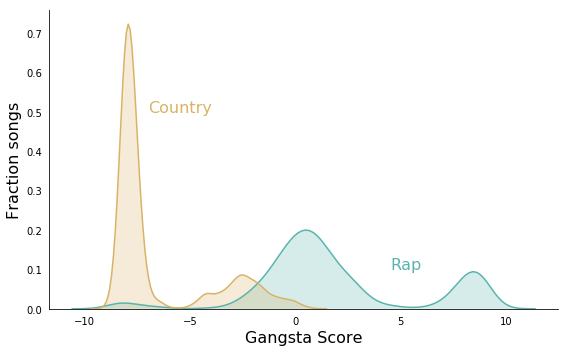

In [59]:
# fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8,9))
plt.figure(figsize=(8,5))

sns.kdeplot(rap_combo['Log_Diff'], label='rap', color=tr_color, shade=True);
sns.kdeplot(cnty_lda_df['Log_Diff'], label='country', color=tc_color,  shade=True);

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.legend().set_visible(False)

plt.tick_params(left=False, bottom=False)

plt.xlabel("Gangsta Score", fontsize=16)
plt.ylabel("Fraction songs", fontsize=16)

# plt.yticks(np.arange(0,10),)
plt.text(x=4.5, y=0.1, s="Rap", color=tr_color, fontsize=16)
plt.text(x=-7, y=0.5, s="Country", color=tc_color, fontsize=16)

plt.savefig('Images/score_hist_overlay_2cat.png', dpi=300, transparent=False)


In [52]:
combo_lda_df = pd.concat([rap_rap_lda_df, rap_cnty_lda_df, cnty_cnty_lda_df])
combo_lda_df['Log_Diff'] = np.log(combo_lda_df[1]) - np.log(combo_lda_df[0])
combo_lda_df.groupby('cat')['Log_Diff'].aggregate(['min','max','mean', 'std'])

,min,max,mean,std
cat,,,,
country rap,-8.788898,-0.435287,-3.969639,2.982807
true country,-8.895361,-0.241945,-6.782238,2.157996
true rap,-6.402002,9.584596,3.130577,3.306130


/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


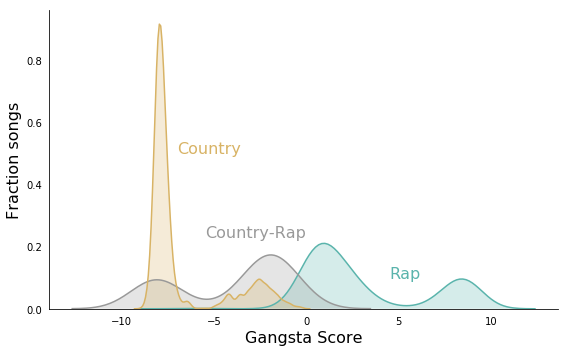

In [58]:
# fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8,9))
plt.figure(figsize=(8,5))

bins = np.arange(-10,10)

# plt.subplot(3,1,1)
sns.kdeplot(combo_lda_df[combo_lda_df['cat'] == 'true rap']['Log_Diff'], label='true rap', color=tr_color,
         shade=True);

# plt.subplot(3,1,2)
sns.kdeplot(combo_lda_df[combo_lda_df['cat'] == 'country rap']['Log_Diff'], label='country rap', 
         color=cr_color,  shade=True);

# plt.subplot(3,1,3)
sns.kdeplot(combo_lda_df[combo_lda_df['cat'] == 'true country']['Log_Diff'], label='true country', 
         color=tc_color,  shade=True);


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend().set_visible(False)
plt.tick_params(left=False, bottom=False)
# plt.legend(loc=0, fontsize=14,frameon=False);
# ax = plt.gca()
# u.hide_axes(ax, False, False, True, False)
plt.xlabel("Gangsta Score", fontsize=16)
plt.ylabel("Fraction songs", fontsize=16)

# plt.yticks(np.arange(0,10),)
plt.text(x=4.5, y=0.1, s="Rap", color=tr_color, fontsize=16)
plt.text(x=-7, y=0.5, s="Country", color=tc_color, fontsize=16)
plt.text(x=-5.5, y=0.23, s="Country-Rap", color=cr_color, fontsize=16)


plt.savefig('Images/score_hist_overlay_3cat.png', dpi=300, transparent=False)


/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


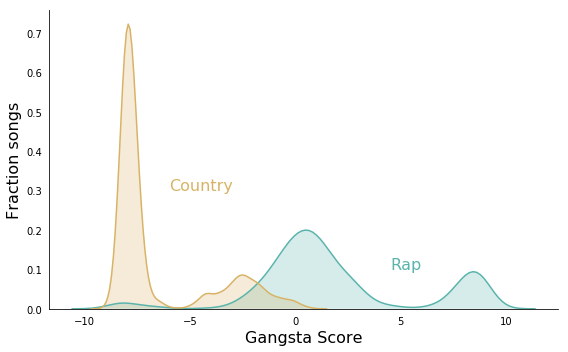

In [51]:
# fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8,9))
plt.figure(figsize=(8,5))

sns.kdeplot(rap_combo['Log_Diff'], label='rap', color=tr_color, shade=True);
sns.kdeplot(cnty_lda_df['Log_Diff'], label='country', color=tc_color,  shade=True);

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.legend().set_visible(False)

plt.tick_params(left=False, bottom=False)

plt.xlabel("Gangsta Score", fontsize=16)
plt.ylabel("Fraction songs", fontsize=16)

# plt.yticks(np.arange(0,10),)
plt.text(x=4.5, y=0.1, s="Rap", color=tr_color, fontsize=16)
plt.text(x=-6, y=0.3, s="Country", color=tc_color, fontsize=16)

plt.savefig('Images/score_hist_overlay_2cat.png', dpi=300, transparent=False)


## Average 'Gangsta' score by artist

In [ ]:
df['Gangsta Score'] = u.gangsta_score(df.index, lda_X)

In [ ]:
artist_scores = pd.DataFrame(df.groupby('Artist')['Gangsta Score', 'Song']
                             .aggregate({'Gangsta Score': 'mean', 'Song': 'count'}))
artist_scores['Genre'] = ['rap' if x in rap_df['Artist'].values else 'country' for x in artist_scores.index]

In [ ]:
full_artist_scores = artist_scores.copy()

In [ ]:
artist_scores = artist_scores[artist_scores['Song'] > 2]

In [ ]:
most_gangsta = artist_scores[artist_scores['Genre'] == 'rap'].sort_values('Gangsta Score')
most_country = artist_scores[artist_scores['Genre'] == 'country'].sort_values('Gangsta Score', ascending=False)
least_gangsta = artist_scores[artist_scores['Genre'] == 'rap'].sort_values('Gangsta Score', ascending=False)
least_country = artist_scores[artist_scores['Genre'] == 'country'].sort_values('Gangsta Score')

In [ ]:
least_country.head(10)

In [ ]:
u.random_example_score(-5, artist_scores)

In [ ]:
artist_scores.to_csv('Data/artist_scores.csv')